KNN --> SGD --> RFC
Train Accuracy:  0.8007448789571695


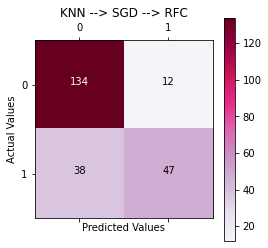

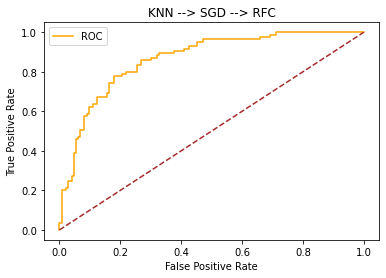

Test Accuracy:  0.7835497835497836
KNN --> RFC --> SGD
Train Accuracy:  0.6759776536312849


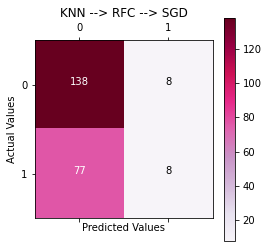

Test Accuracy:  0.6320346320346321
SGD --> KNN --> RFC
Train Accuracy:  0.8007448789571695


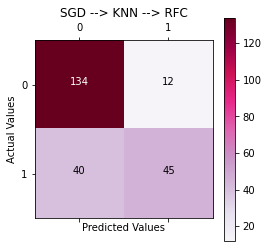

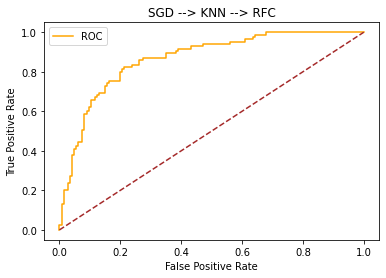

Test Accuracy:  0.7748917748917749
SGD --> RFC --> KNN
Train Accuracy:  0.7802607076350093


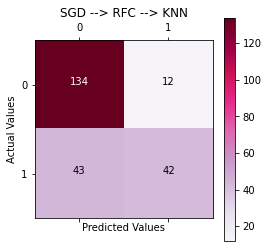

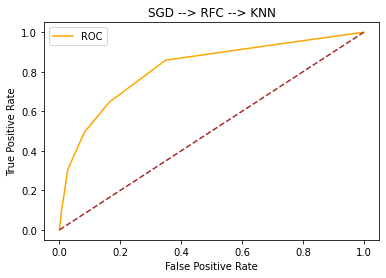

Test Accuracy:  0.7619047619047619
RFC --> KNN --> SGD
Train Accuracy:  0.36685288640595903


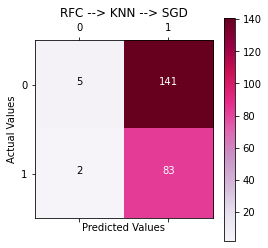

Test Accuracy:  0.38095238095238093
RFC --> SGD --> KNN
Train Accuracy:  0.7802607076350093


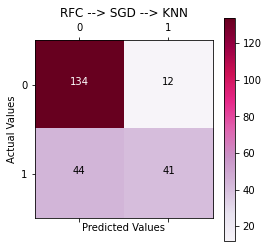

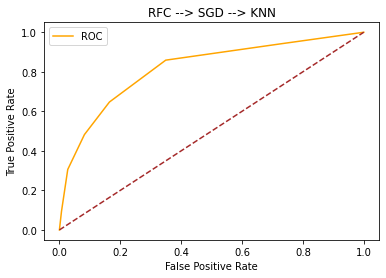

Test Accuracy:  0.7575757575757576
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       146
           1       0.77      0.48      0.59        85

    accuracy                           0.76       231
   macro avg       0.76      0.70      0.71       231
weighted avg       0.76      0.76      0.74       231

Best Accuracy Score (Maximum) :  0.7835497835497836
Sequence having maximum accuracy:  ['KNN', 'SGD', 'RFC']


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import classification_report


#Reading the dataset -> diabetic dataset
def read_data():
    df = pd.read_csv("diabetic_dataset.csv")
    df['class'] = df['class'].replace({'tested_negative': 0, 'tested_positive': 1})
    X = df.iloc[:, :-1]
    y = df[['class']]    
    return X, y


#Confusion Matrix plotting 
def confusion_matrix_plot(y_test, y_pred, model):
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap=plt.cm.PuRd)
    plt.title('{}'.format(model))
    plt.colorbar()
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')    
    plt.show()


#Receiver Operating Characteristics Curve (ROC Curve) plotting
def roc_curve_plot(fp, tp, model_name):
    plt.plot(fp, tp, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='brown', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}'.format(model_name))
    plt.legend()
    plt.show()


#The model enumeration and training of the sets of value
def cascading(models, X_train, y_train, test=False):
    for i, model in enumerate(models):
        if not test:
            model[1].fit(X_train, y_train.values.ravel())
        if i != len(models) - 1:
            X_train.insert(X_train.shape[1], "T{}".format(i), model[1].predict(X_train), True)
    return model


#Main
#KNearestNeighbor - KNN uses n values that are even as even values gives optimal solution
#RandomForestClassifier- RFC uses the random state as 0 to avoid the values to be inconsistent
#StochasticGradientDescent- SGD uses log as the logistic regression must be trained. 

if __name__ == "__main__":
    acc_max = 0
    best_sequence = None
    models = [
        ("KNN", KNeighborsClassifier(n_neighbors=6, n_jobs=-1)),
        ("SGD", SGDClassifier(loss='log')),
        ("RFC", RandomForestClassifier(random_state=0, n_jobs=-1,
                               n_estimators=100, max_depth=3))
    ]
    
    for each in list(itertools.permutations(models)):
        X, y = read_data()
        sequence = ""
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        model = cascading(each, X_train, y_train)
        
        #getting the values for the train accuracy
        X_pred = model[1].predict(X_train)
        acc_train = accuracy_score(y_train, X_pred)
        
        for count, i in enumerate(each):
            sequence += i[0]
            if count != len(each) - 1:
                sequence += " --> "
        print(sequence)
        #Printing the training accuracy
        print("Train Accuracy: ", acc_train)
        
        #cascading
        model = cascading(each, X_test, y_test, test=True)
        y_pred = model[1].predict(X_test)
        acc_test = accuracy_score(y_test, y_pred)
        confusion_matrix_plot(y_test, y_pred, sequence)
        
        #Obtaining the test accuracy
        if model[0] != "SGD":
            prob = model[1].predict_proba(X_test)
            prob = prob[:, 1]
            fp, tp, thresholds = roc_curve(y_test, prob)
            roc_curve_plot(fp, tp, sequence)
        print("Test Accuracy: ", acc_test)
        
        #checks and obtains the best sequence and update it
        if acc_test > acc_max:
            acc_max = acc_test
            best_sequence = [i[0] for i in each]

    print(classification_report(y_test,y_pred))
    print('Best Accuracy Score (Maximum) : ', acc_max)
    print('Sequence having maximum accuracy: ', best_sequence)